In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import warnings
warnings.filterwarnings('ignore')

## 1. Get the Data

In [3]:
# Obtained from https://github.com/ewenme/transfers
path = "./data/"
year = 1992
li = []
for i in range(1,28):
    all_files = glob.glob(path + "/" + str(year) + "/*.csv")
   
    for filename in all_files:
        df = pd.read_csv(filename)
        li.append(df)
    year = year+1

df = pd.concat(li, axis=0, ignore_index=True)

Dimension and Variables:

In [4]:
print("Dataframe has shape: " + "\n" + str(df.shape) +  '\n\n' + "And Variables: ")

for col in df.columns: 
    print(col)

Dataframe has shape: 
(160173, 11)

And Variables: 
club_name
player_name
age
position
club_involved_name
fee
transfer_movement
fee_cleaned
league_name
year
season


In [37]:
df.head(2)

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,league_name,year,season
0,Milan AC,Jean-Pierre Papin,28.0,Centre-Forward,Marseille,£10.80m,in,10.8,Serie A,1992,1992/1993
1,Milan AC,Gianluigi Lentini,23.0,Right Winger,Torino,£8.60m,in,8.6,Serie A,1992,1992/1993


Let's have a first look on which league has the most overall movements:

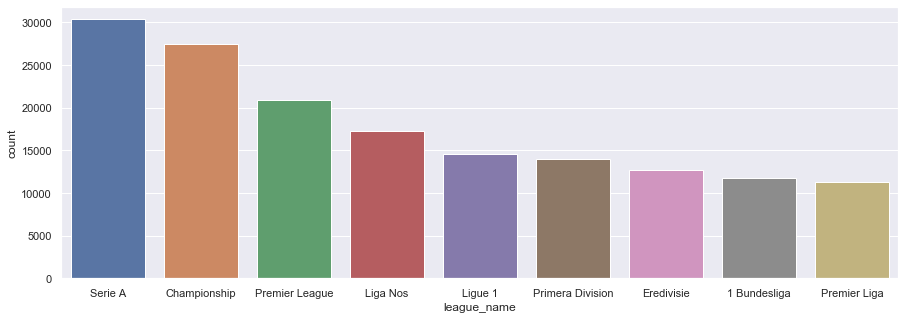

In [38]:
fig, ax = plt.subplots(figsize=[15,5])
sns.countplot(ax=ax, x="league_name", data=df,  order = df['league_name'].value_counts().index)

This is already interesting but we need to dive deeper, and before we do that we need to wrangle our dataset..

## 2. Wrangling

### I. Drop NaNs

In [39]:
df.isna().sum() / df.shape[0] *100

club_name              0.000000
player_name            0.000000
age                    0.036835
position               0.000624
club_involved_name     0.000000
fee                    0.104262
transfer_movement      0.000000
fee_cleaned           15.629351
league_name            0.000000
year                   0.000000
season                 0.000000
dtype: float64

Our dataset is quite complete but we want to know where the ~15% of missing values for the cleaned transfer fee come from.

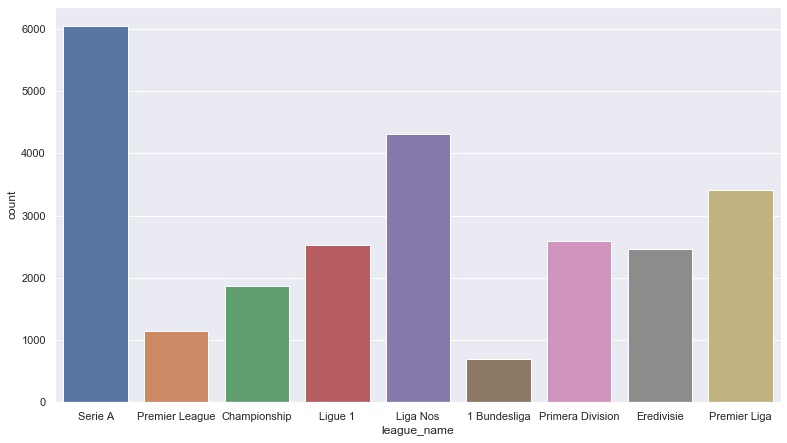

In [40]:
sns.set(rc={'figure.figsize':(13,7.27)})
sns.countplot(x="league_name", data=df[(df["fee_cleaned"].isna() == True) | (df["age"].isna() == True)])

We find that most of the missing values come from transfers where Italian clubs were involved. Data from the Bundesliga and Premier League is the completest. We are going to drop any row with NaNs and work with a complete dataset from here on.

In [41]:
df = df.dropna()

### II. Filter for Age between 16 and 45

One assumption that intuitively makes sense is that most of the players that are older than 40 are goalkeepers.

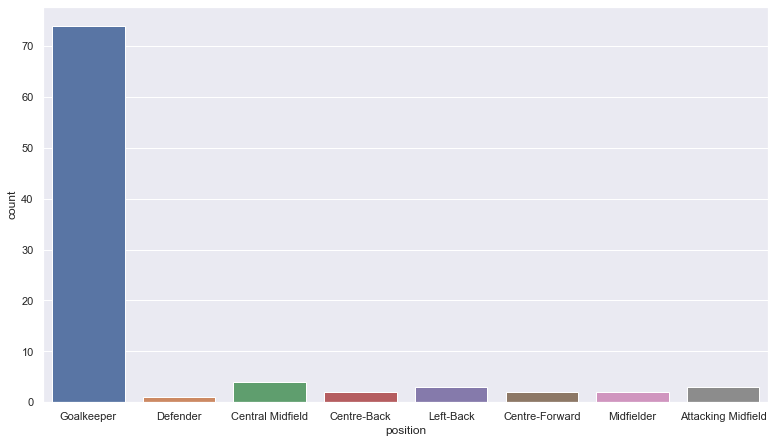

In [42]:
sns.countplot(x="position", data=df[df["age"] > 40])

In [43]:
df = df[(df["age"] >= 16) & (df["age"] <= 45)]

### III. Filter by Leagues and definite Transfers (no loans)

We will create another dataframe that also keeps the other leagues (except the Championship, because it is 2nd Division), which we will need later when we analyse the loan transfers:

In [44]:
df_top8_leagues = df[df["league_name"] != "Championship"]

In [45]:
def is_loan(x):
    if "Loan" in x:
        return "start"
    if "End of loan" in x:
        return "end"
    return "no"

# can take no, start, end
df_top8_leagues.loc[:, "loan"] = df_top8_leagues["fee"].map(lambda x: is_loan(x))

In [46]:
#drop irrelevant columns
df_top8_leagues = df_top8_leagues.drop(["season", "fee", "fee_cleaned"], axis = 1)

In [47]:
# keep top leagues only
leagues = ['Premier League', 'Ligue 1', '1 Bundesliga', 'Serie A', 'Primera Division']
df = df[df["league_name"].isin(leagues) == True]

In [48]:
def get_country(league):
    if league == "Premier League":
        country = "ENG"
    elif league == "Ligue 1":
        country = "FRA"
    elif league == "1 Bundesliga":
        country = "GER"
    elif league == "Serie A":
        country = "ITA"
    elif league == "Primera Division":
        country = "ESP"
    else:
        country = "unknown"
        
    return country

df["country"] = df["league_name"].map(lambda x: get_country(x))

In [50]:
df_top8_leagues.shape

(109475, 9)

### IV. Keep only incoming transfer records

For our original dataframe we want to only keep the incoming transfer records. They reflect the financial power and willingness to pay (high) fees.

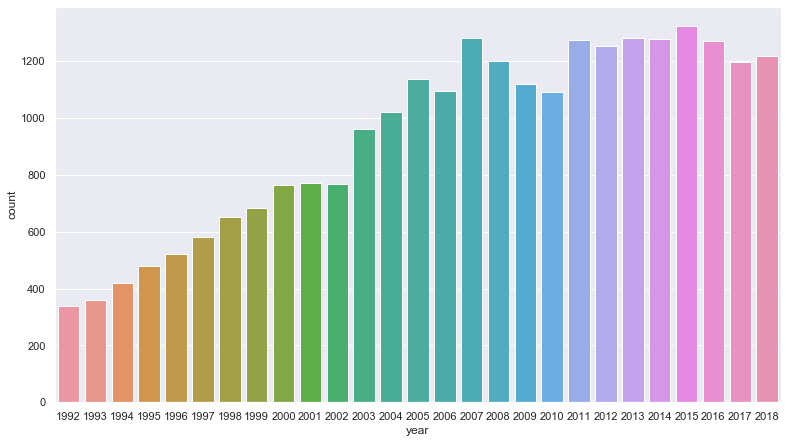

In [51]:
# Drop end of loan records 
df = df[df["fee"].str.contains("loan") == False]

# Drop outgoing records
df = df[df["transfer_movement"] == "in"]
sns.countplot(df["year"])

There has been a constant growth of incoming transfers until around 2005-2007, from there on the level stayed the same.

## 3. Adjust for Inflation

In order to compare transfer spendings from different years we have to adjust for inflation.

In [52]:
# source: https://data.oecd.org/price/inflation-cpi.htm
inflations = {}
inflations["ENG"] = [1.7171,1.6736,1.6376,1.5945,1.5496,1.5162,1.4894,1.4645,1.4472,1.4244,1.4033,1.3839,1.3648,1.3368,1.3042,1.2736,1.2305,1.2064,1.1770,1.1339,1.1051,1.0803,1.0643,1.0601,1.0496,1.0230,1.0000]
inflations["ESP"] = [1.8936,1.8108,1.7292,1.6521,1.5953,1.5645,1.5363,1.5017,1.4519,1.4015,1.3598,1.3197,1.2807,1.2390,1.1969,1.1644,1.1187,1.1220,1.1021,1.0680,1.0424,1.0279,1.0295,1.0347,1.0367,1.0168,1.0000]
inflations["FRA"] = [1.4470,1.4173,1.3941,1.3695,1.3429,1.3270,1.3184,1.3113,1.2896,1.2689,1.2450,1.2194,1.1939,1.1734,1.1540,1.1370,1.1059,1.1050,1.0883,1.0658,1.0454,1.0365,1.0313,1.0308,1.0290,1.0185,1.0000]
inflations["GER"] = [1.5082,1.4437,1.4059,1.3822,1.3625,1.3366,1.3245,1.3167,1.2980,1.2728,1.2550,1.2422,1.2218,1.2032,1.1845,1.1578,1.1282,1.1247,1.1124,1.0898,1.0683,1.0525,1.0430,1.0377,1.0327,1.0173,1.0000]
inflations["ITA"] = [1.7611,1.6831,1.6176,1.5371,1.4778,1.4483,1.4204,1.3972,1.3626,1.3256,1.2937,1.2600,1.2328,1.2087,1.1840,1.1627,1.1250,1.1164,1.0996,1.0699,1.0383,1.0258,1.0233,1.0229,1.0238,1.0114,1.0000]

inflations_dict = {}
for country in ["ENG", "ESP", "FRA", "GER", "ITA"]:
    inflations_dict[country] = {}
    for i in zip(inflations[country], range(1992,2019)):
        inflations_dict[country][i[1]] = i[0]

In [53]:
def get_inflation(country,year):
    return inflations_dict[country][year]

df["inflation_rate"] = df.apply(lambda x: get_inflation(x["country"], x["year"]), axis=1)
df["fee_adjusted"] = df["fee_cleaned"] * df["inflation_rate"]

## 4. Create different kinds of dataframes

- I. Dataframe that contains all transfers
- II. Dataframe that contains only loans
- III. Dataframe that contains only purchases
- IV. Dataframe that contains all free transfers

In [55]:
df_all = df.copy()
df_loans = df[df["fee"].str.contains("Loan") == True]
df_monetized = df[(df["fee"].str.contains("Loan") == False) & (df["fee_cleaned"] > 0)]
df_free = df[(df["fee"].str.contains("Loan") == False) & (df["fee_cleaned"] == 0)]

The dimensions are:

In [56]:
print("df_all: " + str(df_all.shape) + ",\ndf_loans: " + str(df_loans.shape) + ",\ndf_monetized: " + str(df_monetized.shape) +
     ", \ndf_free: " + str(df_free.shape))

df_all: (25341, 14),
df_loans: (4628, 14),
df_monetized: (9896, 14), 
df_free: (10817, 14)


In [57]:
df_top8_leagues.shape

(109475, 9)

## 5. Insight #1: Development of transfer spending mean

People often claim that the market is getting more insane recently and that transfer spendings have reached an "immoral" point. However, we can see that the mean transfer fees at the beginning of the millenium are not that far from today's level.

The spike in the late 1990s and early 2000s seems to be driven mainly by a decade of increased spendings in Italy and Spain, whereas the increase starting with the 2010s is driven by higher transfer fees payed by English clubs.

Bundesliga and Ligue 1 see more or less stable mean transfer fees across the years.

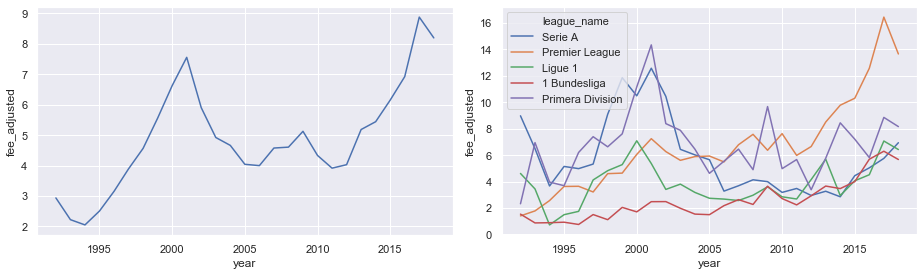

In [58]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))  # 1 row, 2 columns
sns.lineplot(x="year", y="fee_adjusted",  data=df_monetized, ci=None, estimator=np.mean, ax=ax1)
sns.lineplot(x="year", y="fee_adjusted",  hue="league_name", data=df_monetized, ci=None, estimator=np.mean, ax=ax2)

plt.tight_layout() 

If you look at the distribution of transfer fees since 1992, it seems that there is a quite stable mean ranging in the single-digit million area. In some years the distribution shifts towards somewhat higher spendings, but reverts quickly to its usual shape.

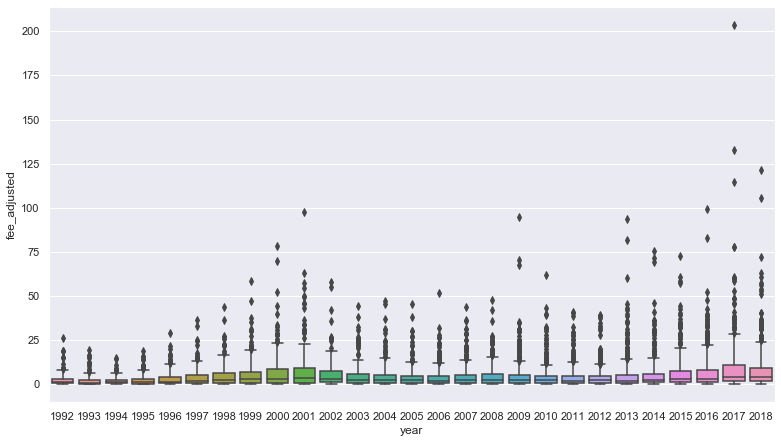

In [59]:
# change whisker size (in std devs)
whis = 2
sns.boxplot(x="year", y="fee_adjusted", data=df_monetized, whis=whis)

If restricted to only statistical outliers, however, the picture somewhat changes. First, there is a clear trend towards a larger number of extreme, i.e. more expensive, transfers per year, even when accounting for inflation. Second, the mean of those extreme transfers have been rising constantly over the last 10-15 years (ignoring the Italian-Spanish Spike in the early 2000s). These two trends together lead to a significant increase of total transfer market spendings (~300% increase in the last 20 years), which is likely driving the popular opinion of a transfer market which is out of control.


Note that to qualify as an outlier, an observations needs to be larger than a calculated maximum value for any given distribution. Here, outliers are calculated more conservatively than usual, the "whis" parameter in the cell above can easily be changed to examine other calculations. For more on outliers/boxplots, see https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51.

In [60]:
from matplotlib.cbook import boxplot_stats  

counts = []
means = []
sums = []
years = []

for year in df_monetized["year"].unique():
    counts.append(len(boxplot_stats(df_monetized[df_monetized["year"]==year]["fee_adjusted"], whis=whis).pop(0)['fliers']))
    means.append(np.mean(boxplot_stats(df_monetized[df_monetized["year"]==year]["fee_adjusted"], whis=whis).pop(0)['fliers']))
    sums.append(np.sum(boxplot_stats(df_monetized[df_monetized["year"]==year]["fee_adjusted"], whis=whis).pop(0)['fliers']))
    years.append(year)

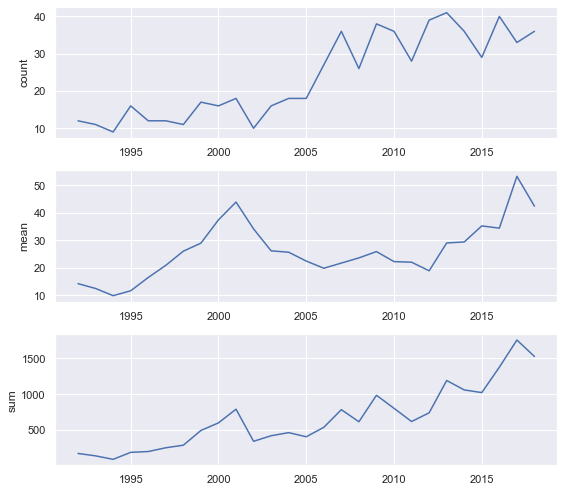

In [65]:
fliers = pd.DataFrame(data={"count":counts, "mean":means, "sum":sums}, index=years)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(8,7))  # 1 row, 2 columns
sns.lineplot(x=fliers.index, 
            y=fliers["count"], 
            ax=ax1)
sns.lineplot(x=fliers.index, 
             y=fliers["mean"], 
             ax=ax2)
sns.lineplot(x=fliers.index, 
             y=fliers["sum"], 
             ax=ax3)
plt.tight_layout() 

## 6. Insight #2: Development of total transfer revenue

This graph probably represents better what most people believe. There are indeed much more pricy transfers recently that add up to more revenue created. Hence, the difference between the 2000s and today is much more significant if we look at the sum.

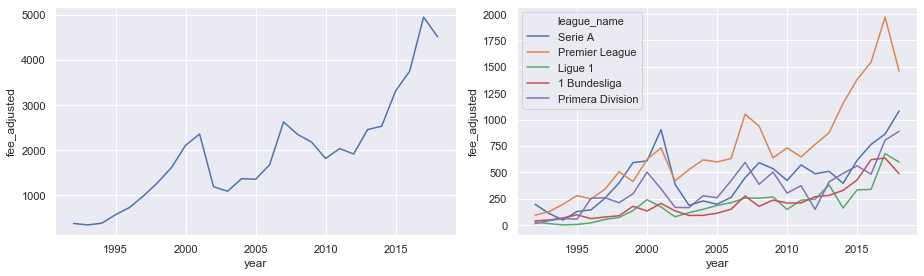

In [66]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))  # 1 row, 2 columns
sns.lineplot(x="year", y="fee_adjusted",  data=df_monetized, ci=None, estimator=np.sum, ax=ax1)
sns.lineplot(x="year", y="fee_adjusted",  hue="league_name", data=df_monetized, ci=None, estimator=np.sum, ax=ax2)

plt.tight_layout() 

The reason for that is partly because there are in general more transfers than earlier (as we showed at the beginning). Players are less often loyal and won't fullfill their contracts anymore.

## 7. Insight #3: Development of percentage of players on loan

In [69]:
df_top8_leagues_loans = df_top8_leagues[df_top8_leagues["loan"] == "start"].groupby(['year', 'league_name'])["loan"].count().reset_index()
df_top8_leagues_all = df_top8_leagues.groupby(['year', 'league_name'])["transfer_movement"].count().reset_index()

In [70]:
df_top8_leagues_loans = pd.merge(df_top8_leagues_loans, df_top8_leagues_all, on=['year', 'league_name'])

In [71]:
df_top8_leagues_loans["percentage"] = df_top8_leagues_loans["loan"] / df_top8_leagues_loans["transfer_movement"] 

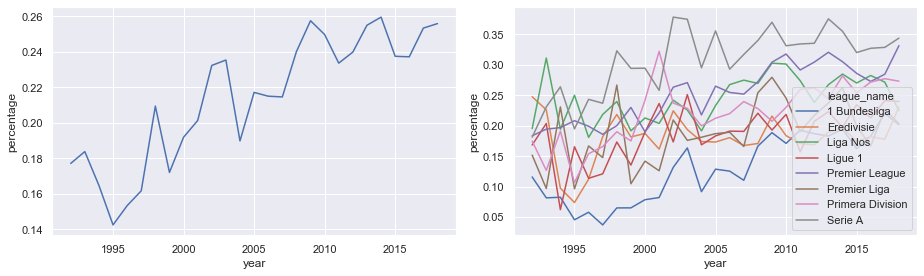

In [72]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))  # 1 row, 2 columns
sns.lineplot(x="year", y="percentage", data=df_top8_leagues_loans, ci=None, ax=ax1)
sns.lineplot(x="year", y="percentage",  hue="league_name", data=df_top8_leagues_loans, ci=None,  ax=ax2)

plt.tight_layout() 

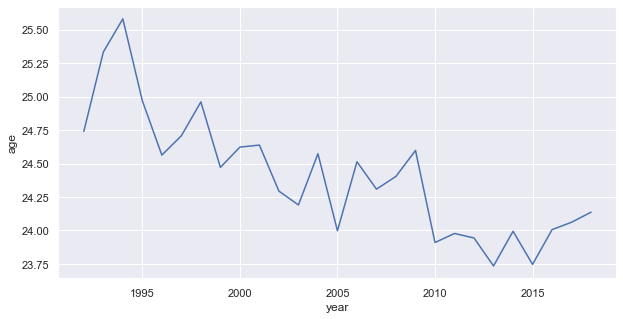

In [76]:
sns.set(rc={'figure.figsize':(10,5)})
sns.lineplot(x="year", y="age",  data=df_monetized, estimator = np.mean, ci=None)

## 8. Insight #4: Development by Position

In [77]:
positions = {'Centre-Back':"Defense", 'Central Midfield':"Midfield", 'Defensive Midfield':"Midfield",
       'Right Midfield':"Midfield", 'Forward':"Striker", 'Right-Back':"Defense", 'Second Striker':"Striker",
       'Centre-Forward':"Striker", 'Midfielder':"Midfield", 'Attacking Midfield':"Midfield", 'Left-Back':"Defense",
       'Left Winger':"Striker", 'Right Winger':"Striker", 'Defender':"Defense", 'Sweeper':"Defense",
       'Left Midfield':"Midfield"}

df_monetized_positions = df_monetized.replace(positions)

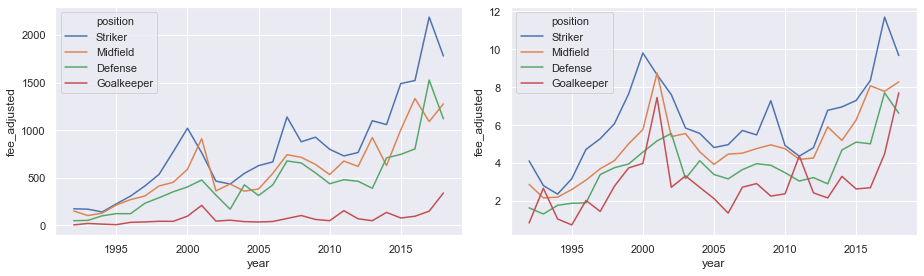

In [78]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(13,4))  # 1 row, 2 columns
sns.lineplot(x="year", y="fee_adjusted",  hue="position", data=df_monetized_positions, ci=None, estimator=np.sum, ax=ax1)
sns.lineplot(x="year", y="fee_adjusted",  hue="position", data=df_monetized_positions, ci=None, estimator=np.mean, ax=ax2)

plt.tight_layout() 